# **Oxford Pets Image Segmentation with U-Net**

## Overview

In this notebook, we’ll build a Convolutional Neural Network based on the U-Net architecture to perform image segmentation on the Oxford Pets dataset.

Following steps:
1. Load and explore the dataset
2. Preprocess the images and masks
3. Define and build the U-Net model
4. Train the model using a learning rate scheduler and early stopping
5. Visualize the model's performance with sample predictions

### 1. Import Libraries

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import random
from tensorflow.keras.utils import array_to_img
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")


### 2. Download and Prepare the Dataset
Download the Oxford-IIIT Pet dataset.


In [ ]:
# Download and extract the dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-11-13 20:52:54--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-11-13 20:52:54--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-13 20:52:55--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

### 3. Define Image and Target Paths
Load and sort the image and mask paths.

In [ ]:
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

In [ ]:
print(len(input_img_paths))
print(len(target_img_paths))

7390
7390


### 4. Display Sample Images and Mask

Display a sample image and its corresponding segmentation mask.

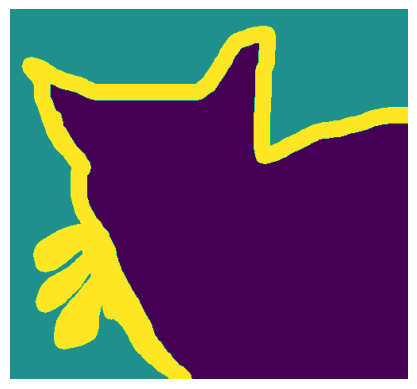

In [ ]:
load_img(input_img_paths[4])
def display_target(img):
    normalized_img = (img.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_img[:, :, 0])

img = load_img(target_img_paths[4], color_mode='grayscale')
img = img_to_array(img)
display_target(img)

### 5. Define Preprocessing Functions

Define helper functions for loading, resizing, and normalizing images and masks.

In [ ]:
img_size = (256, 256)

In [ ]:
def path_to_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [ ]:
def path_to_target(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.uint8) - 1
    return img

In [ ]:
def map_fn(img_path, target_path):
    img = path_to_img(img_path)
    mask = path_to_target(target_path)
    return img, mask

### 6. Data Augmentation

Apply data augmentation techniques like flipping, adjusting brightness, and contrast.


In [ ]:
def augment_data(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask

### 7. Prepare Dataset

Prepare the datasets for training and validation, applying augmentation only to the training set.

In [ ]:
def prepare_dataset(image_paths, mask_paths, batch_size, should_augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if should_augment:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
num_valid_samples = 1000
train_dataset = prepare_dataset(input_img_paths[:-num_valid_samples],
                                target_img_paths[:-num_valid_samples],
                                batch_size=32, should_augment=True)

valid_dataset = prepare_dataset(input_img_paths[-num_valid_samples:],
                                target_img_paths[-num_valid_samples:],
                                batch_size=32, should_augment=False)

### 8. Build the U-Net Model

The U-Net model consists of an encoder and a decoder.


In [ ]:
def unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model

num_classes = 3
model = unet_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 256)  │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

### Step 9. Compile the Model with Optimizer and Early Stopping.

In [ ]:
initial_learning_rate = 1e-4

optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_unet.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                      factor=0.5,
                                      patience=5,
                                      min_lr=1e-6,
                                      verbose=1),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(train_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=valid_dataset)

Epoch 1/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.5722 - loss: 0.9189 - val_accuracy: 0.6483 - val_loss: 0.7531 - learning_rate: 1.0000e-04
Epoch 2/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.6636 - loss: 0.7741 - val_accuracy: 0.6888 - val_loss: 0.7237 - learning_rate: 1.0000e-04
Epoch 3/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.6902 - loss: 0.7302 - val_accuracy: 0.7072 - val_loss: 0.6764 - learning_rate: 1.0000e-04
Epoch 4/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.7114 - loss: 0.6951 - val_accuracy: 0.7181 - val_loss: 0.6555 - learning_rate: 1.0000e-04
Epoch 5/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.7225 - loss: 0.6615 - val_accuracy: 0.7452 - val_loss: 0.6080 - learning_rate: 1.0000e-04
Epoch 6/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.7389 - loss: 0.6325 - val_accuracy: 0.7577 - val_loss: 0.5800 - learning_rate: 1.0000e-04
Epoch 7/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - acc

### Step 10. Visualize Training History

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1 , 2 ,1 )
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1 , 2 ,2 )
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load the best model and make predictions
model=keras.models.load_model("oxford_segmentation_unet.keras")

def display_mask(pred):
   mask=np.argmax(pred , axis=-1)
   mask*=127
   return mask

# Visualize predictions
num_display=5
for i in range(num_display):
   idx=np.random.randint(len(input_img_paths))
   test_image=load_img(input_img_paths[idx], target_size=img_size)
   test_image_array=img_to_array(test_image)/255.0

   mask=model.predict(np.expand_dims(test_image_array , axis=0))[0]

   plt.figure(figsize=(12 ,4 ))
   plt.subplot(1 ,3 ,1 )
   plt.title("Input Image")
   plt.imshow(test_image )
   plt.axis("off")

   plt.subplot(1 ,3 ,2 )
   plt.title("Ground Truth")
   gt_mask=load_img(target_img_paths[idx], target_size=img_size , color_mode="grayscale")
   plt.imshow(gt_mask , cmap="gray")
   plt.axis("off")

   plt.subplot(1 ,3 ,3 )
   plt.title("Predicted Mask")
   plt.imshow(display_mask(mask), cmap="gray")
   plt.axis("off")

   plt.tight_layout()
   plt.show()

### End